## Punny Captions - Automated Image Captioning
Author: Jishu Basak


## 1. Problem Statement
Creating an Image Captioning application using Deep Learning algorithms


### 1.1 Introduction:

Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a given photograph.

It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order.

Deep learning methods have demonstrated state-of-the-art results on caption generation problems. What is most impressive about these methods is a single end-to-end model can be defined to predict a caption, given a photo, instead of requiring sophisticated data preparation or a pipeline of specifically designed models.

### 1.2 Prerequisites
This post assumes familiarity with basic Deep Learning concepts like Convolution Neural Networks, Transfer Learning, Recurrent Neural Networks, Gradient Descent, Feed-Forward, Back-propagation, Text Processing, Python, Keras library etc and concepts of Natural Language Processing such as Word Embedding.

**In addition to that I would urgeg you to download the Flicker 8k dataset( 2 Giga Bytes, GLove 6B 200d word embedding pretrained model and Inceptionv3 installed in your machine)**

GLove Pretrained model download link: http://nlp.stanford.edu/data/glove.6B.zip

Flicker Dataset: https://github.com/HUOd/image-captioning (Images + text)


## 2. Methodology
### 2.1 Data Collection
There are many open source datasets available for this problem, like Flickr 8k (containing8k images), Flickr 30k (containing 30k images), MS COCO (containing 180k images), etc.
But for the purpose of this case study, I have used the Flickr 8k dataset which you can download by filling this form provided by the University of Illinois at Urbana-Champaign. Also training a model with large number of images may not be feasible on a system which is not a very high end PC/Laptop.
This dataset contains 8000 images each with 5 captions.


These images are distributed as follows:

`Training Set` — 6000 images

`Dev Set` — 1000 images


`Test Set` — 1000 images

##### Loading the Libraries

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


If you have downloaded the data from the link you will also get some text files related to the images. One of the files is “Flickr8k.token.txt” which contains the name of each image along with its 5 captions.

### 2.2 Loading the prerequisite files

In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = "Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


Now, we create a dictionary named “descriptions” which contains the name of the image (without the .jpg extension) as keys and a list of the 5 captions for the corresponding image as values.

In [3]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


For example with reference to the above screenshot the dictionary will look as follows:

In [5]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

### 2.3 Data Cleaning

Some basic cleaning like lower-casing all the words (otherwise“hello” and “Hello” will be regarded as two separate words), removing special tokens (like ‘%’, ‘$’, ‘#’, etc.), eliminating words which contain numbers (like ‘hey199’, etc.).

In [4]:
def clean_descriptions(descriptions):
# prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [9]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

Create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions (corpus) in the data set :

In [5]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


This means we have 8763 unique words across all the 40000 image captions. 

In [6]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

However, if we think about it, many of these words will occur very few times, say 1, 2 or 3 times. Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. This helps the model become more robust to outliers and make less mistakes.
Hence we consider only those words which occur at least 10 times in the entire corpus.

### 2.4 Loading the training dataset
The text file “Flickr_8k.trainImages.txt” contains the names of the images that belong to the training set. So we load these names into a list “train”.

In [7]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


Thus we have separated the 6000 training images in the list named “train”.

Now, we load the descriptions of these images from “descriptions.txt” (saved on the hard disk) in the Python dictionary “train_descriptions”.

However, when we load them, we will add two tokens in every caption as follows (significance explained later):

‘startseq’ -> This is a start sequence token which will be added at the start of every caption.

‘endseq’ -> This is an end sequence token which will be added at the end of every caption.

In [8]:
# Below path contains all the images
images = 'Flickr8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [9]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [10]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [11]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


### 2.5 Data Preprocessing — Images

We need to convert every image into a fixed sized vector which can then be fed as input to the neural network. For this purpose, we opt for transfer learning by using the InceptionV3 model (Convolutional Neural Network) created by Google Research.


This model was trained on Imagenet dataset to perform image classification on 1000 different classes of images. However, our purpose here is not to classify the image but just get fixed-length informative vector for each image. This process is called automatic feature engineering.


Hence, we just remove the last softmax layer from the model and extract a 2048 length vector (bottleneck features) for every image as follows:

<img src='inceptionv3.png'>

In [12]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [13]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
import pickle
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [14]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


### 2.6 Data Preprocessing — Captions
We must note that captions are something that we want to predict. So during the training period, captions will be the target variables (Y) that the model is learning to predict.

But the prediction of the entire caption, given the image does not happen at once. We will predict the caption word by word. Thus, we need to encode each word into a fixed sized vector. However, this part will be seen later when we look at the model design, but for now we will create two Python Dictionaries namely “wordtoix” (pronounced — word to index) and “ixtoword” (pronounced — index to word).

Stating simply, we will represent every unique word in the vocabulary by an integer (index). As seen above, we have 1652 unique words in the corpus and thus each word will be represented by an integer index between 1 to 1652.
These two Python dictionaries can be used as follows:

wordtoix[‘abc’] -> returns index of the word ‘abc’


ixtoword[k] -> returns the word whose index is ‘k’

In [15]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [16]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [17]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [18]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [19]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


### 2.7 Data Preparation using Generator Function
Using Stochastic Gradient Decent, I am aiming to transform partial captions that would be fed to the Recurrent Neural Network

In [20]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### 2.8 Word Embeddings
Each word/index is mapped to a 200-long vector using a pre-trained GLOVE word embedding model. After this,for all the 1652 unique words in our vocabulary, we create an embedding matrix which will be loaded into the model before training.

In [21]:
# Load Glove vectors

embeddings_index = {} # empty dictionary
f = open(os.path.join('glove\\glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [22]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [23]:
embedding_matrix.shape

(1652, 200)

### 2.9 Model Architecture
Since the input consists of two parts, an image vector and a partial caption, we cannot use the Sequential API provided by the Keras library. For this reason, we use the Functional API which allows us to create Merge Models.
First, let’s look at the brief architecture which contains the high level sub-modules:


In [24]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Lets look at the model summary

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

The below plot helps to visualize the structure of the network and better understand the two streams of input:
<img src='model.png'>


The LSTM (Long Short Term Memory) layer is nothing but a specialized Recurrent Neural Network to process the sequence input (partial captions in our case)

Recall that we had created an embedding matrix from a pre-trained Glove model which we need to include in the model before starting the training:

In [31]:
model.layers[2]

Notice that since we are using a pre-trained embedding layer, we need to freeze it (trainable = False), before training the model, so that it does not get updated during the backpropagation.

In [32]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False


Finally we compile the model using the adam optimizer

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

Finally the weights of the model will be updated through backpropagation algorithm and the model will learn to output a word, given an image feature vector and a partial caption. So in summary, we have:

Input_1 -> Partial Caption

Input_2 -> Image feature vector

Output -> An appropriate word, next in the sequence of partial caption provided in the input_1 (or in probability terms we say conditioned on image vector and the partial caption)
Hyper parameters during training:

The model was then trained for 6 epochs with the initial learning rate of 0.001 and 3 pictures per batch (batch size). However after 6 epochs, the learning rate was reduced to 0.0001 and the model was trained on 6 pictures per batch.
This generally makes sense because during the later stages of training, since the model is moving towards convergence, we must lower the learning rate so that we take smaller steps towards the minima. Also increasing the batch size over time helps your gradient updates to be more powerful.

Note that I wasnt granted AI-Forge, hence I wasn't able to train my models for longer epoch. The longer the model is left to train, lesser is the overall loss and better are the quality of captions generated. Thus, in order for the better quality captions, I would urge you to retrain the whole model with higher epochs

In [34]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [34]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('models/model_' + str(i) + '.h5')

Epoch 1/1
1720/2000 [========================>.....] - ETA: 2:28 - loss: 4.2181

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Dell-pc\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-4a75a68e3921>", line 3, in <module>
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  File "C:\Users\Dell-pc\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Dell-pc\Anaconda3\lib\site-packages\keras\engine\training.py", line 1732, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\Dell-pc\Anaconda3\lib\site-packages\keras\engine\training_generator.py", line 220, in fit_generator
    reset_metrics=False)
  File "C:\Users\Dell-pc\Anaconda3\lib\site-packages\keras\engine\training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "C:\Users\Dell-pc\Anaconda3\lib\site-packages\tensorflow_core\python\keras\backend.py"

TypeError: can only concatenate str (not "list") to str

In [27]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [36]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('models/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.6823
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.6567
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.6342
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.6129
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5916
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5761
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5610
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5488
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5363
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5255


In [37]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [39]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4589
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4495
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4380
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4300
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4200
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 2.4085
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3994
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3957
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3877
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.3766


In [40]:
model.save_weights('./model_weights/model_30.h5')

In [26]:
model.load_weights('models/model_6.h5')

In [27]:
images = 'Flickr8k_Dataset/'

In [28]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

So we stop when either of the below two conditions is met:

We encounter an ‘endseq’ token which means the model thinks that this is the end of the caption. (You should now understand the importance of the ‘endseq’ token)

We reach a maximum threshold of the number of words generated by the model.


If any of the above conditions is met, we break the loop and report the generated caption as the output of the model for the given image. 

## 3. Results

In [29]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

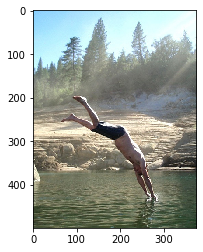


Greedy: man in swim trunks is jumping into lake


In [30]:
z=627
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

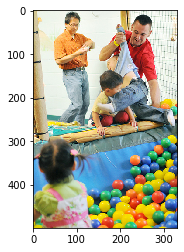

Greedy: two girls play on the ground


In [31]:
z=301
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

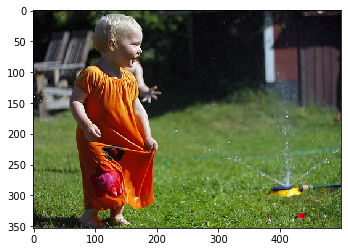

Greedy: young boy is playing with red ball in the grass


In [32]:
z=873
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

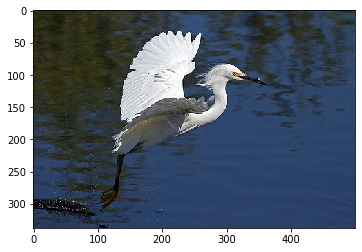

Greedy: white crane is flying over water


In [33]:
z=675
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

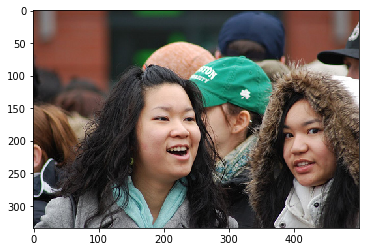

Greedy: man in black shirt and hat is standing next to woman in red shirt


In [34]:
z=201
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

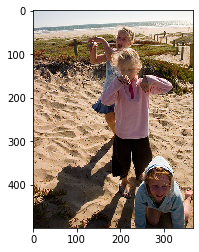

Greedy: boy in red shirt is jumping into the air on the beach


In [35]:
z=19
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

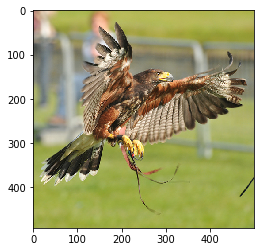

Greedy: dog is running through the grass


In [36]:
z=787
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

It turns out for most of the images trained, the algorithm performs well for some pictures and quite terrible for other images.

One of the reasons that it doesnt perform is due to the fact that algorithm was trained only on few epochs due to computational efficiency and time constraints. Training the model for longer epochs shall yield better results

## 4. Conclusion and Future work

Note that due to the stochastic nature of the models, the captions generated may not be exactly similar to those generated in my case.

### Learnings:
Combination of deep learning models is a good approach towards solving complex Human-AI related problems. 

In this specific project I learned how the fusion of Convolutional Neural Networks with Recurrent Neural Network could actually emancipate text through images. 

Of course this is just a first-cut solution and a lot of modifications can be made to improve this solution like:

- Using a larger dataset.

- Changing the model architecture, e.g. include an attention module.

- Doing more hyper parameter tuning (learning rate, batch size, number of layers, number of units, dropout rate, batch normalization etc.).
- Use the cross validation set to understand overfitting. 

- Using Beam Search instead of Greedy Search during Inference.

- Using BLEU Score to evaluate and measure the performance of the model.


### References:

- https://cs.stanford.edu/people/karpathy/cvpr2015.pdf

- https://arxiv.org/abs/1411.4555

- https://arxiv.org/abs/1703.09137

- https://arxiv.org/abs/1708.02043

- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

- https://www.youtube.com/watch?v=yk6XDFm3J2c

- https://www.appliedaicourse.com/